In [1]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from data_train_test_funcs import mnist_dataloaders, train, sample_images

### Parameters

In [2]:
gpu = True
batch_size = 128
num_workers = 4
epochs = 50
disc_upd_steps = 1

### Dataset definition

In [3]:
train_loader, test_loader = mnist_dataloaders(batch_size=batch_size, num_workers=num_workers, pin_memory=gpu)

### Network definition

In [4]:
class Generator(nn.Module):
    def __init__(self, l_sizes, activation="relu", noise_prior="uniform"):
        super(Generator, self).__init__()
        
        self.l_sizes = [*l_sizes, 784]
        self.activation = activation
        
        # Set noise prior
        if noise_prior == "uniform":
            self.noise_prior = torch.distributions.Uniform(-3, 3)
        elif noise_prior == "normal":
            self.noise_prior = torch.distributions.Normal(0, 3)
        else:
            raise ValueError("No valid prior distribution type selected")
        
        # Generator activation function generator
        if activation == "relu":
            act_fun = nn.ReLU
        elif activation == "leakyrelu":
            act_fun = nn.LeakyReLU
        elif activation == "sigmoid":
            act_fun == nn.Sigmoid
        else:
            raise ValueError("No valid activation function selected")
        
        # Generator
        gen_layers = []
        for idx in range(len(self.l_sizes[:-1])):
            gen_layers.append((f"fc{idx}", nn.Linear(self.l_sizes[idx], self.l_sizes[idx+1])))
            if idx != (len(self.l_sizes) - 2):
                gen_layers.append((f"{activation}{idx}", act_fun()))
#                 gen_layers.append((f"{activation}{idx}", nn.ReLU(True)))
                gen_layers.append((f"dropout{idx}", nn.Dropout(p=0.5)))
            else:  # Sigmoid for final layer
                gen_layers.append((f"sigmoid{idx}", nn.Tanh()))
            
        gen_dict = OrderedDict(gen_layers)
        self.generator = nn.Sequential(gen_dict)
        print(self.generator)
        
    def noise(self, batch_size):
        device = next(self.parameters()).device
        noise = self.noise_prior.rsample((batch_size, self.l_sizes[0]))
        return noise
        
    def forward(self, x):
        y = self.generator(x)
        return y
        
        
class Discriminator(nn.Module):
    def __init__(self, l_sizes, activation="relu"):
        super(Discriminator, self).__init__()
        
        self.l_sizes = [784, *l_sizes, 1]
        self.activation = activation
        
        # Discriminator activation function generator
        if activation == "relu":
            act_fun = nn.ReLU
        elif activation == "leakyrelu":
            act_fun = nn.LeakyReLU
        elif activation == "sigmoid":
            act_fun == nn.Sigmoid
        else:
            raise ValueError("No valid activation function selected")
            
        # Discriminator
        disc_layers = []
        for idx in range(len(self.l_sizes[:-1])):
            disc_layers.append((f"fc{idx}", nn.Linear(self.l_sizes[idx], self.l_sizes[idx+1])))
            if idx != (len(self.l_sizes) - 2):
                disc_layers.append((f"{activation}{idx}", act_fun()))
            else:  # Sigmoid for final layer
                disc_layers.append((f"sigmoid{idx}", nn.Sigmoid()))
            
        disc_dict = OrderedDict(disc_layers)
        self.discriminator= nn.Sequential(disc_dict)
        print(self.discriminator)
        
    def forward(self, x):
        x = x.view(-1, 784)
        y = self.discriminator(x)
        return y

### Training

In [5]:
optim_settings = (0.0001, (0.5, 0.999))
# optim_settings = (0.001, (0.9, 0.999))

# Gen
gen_layers = [32, 200, 400]
generator = Generator(gen_layers, activation="leakyrelu", noise_prior="normal")
gen_optimizer = optim.Adam(generator.parameters(), *optim_settings)

# Discr
discriminator = Discriminator([400, 200], activation="leakyrelu")
disc_optimizer = optim.Adam(discriminator.parameters(), *optim_settings)

# Loss
criterion = nn.BCELoss()

Sequential(
  (fc0): Linear(in_features=32, out_features=200, bias=True)
  (leakyrelu0): LeakyReLU(negative_slope=0.01)
  (dropout0): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200, out_features=400, bias=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=400, out_features=784, bias=True)
  (sigmoid2): Tanh()
)
Sequential(
  (fc0): Linear(in_features=784, out_features=400, bias=True)
  (leakyrelu0): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid2): Sigmoid()
)


In [6]:
def train_step(batch, b_idx):
    
    # generate samples
    x = batch[0]
    noise = generator.noise(x.shape[0]).to(x.device)
    gen_samples = generator(noise)
    
    # Discriminator trainining on real data
    disc_optimizer.zero_grad()
    data_class = discriminator(x)
    data_label = torch.ones((x.shape[0], 1), device=noise.device)
    real_data_loss = criterion(data_class, data_label)
    real_data_loss.backward()
    
    # Discriminator trainining on generated data
    gen_class = discriminator(gen_samples.detach())
    gen_label = torch.zeros((x.shape[0], 1), device=noise.device)
    gen_data_loss = criterion(gen_class, gen_label)
    gen_data_loss.backward()
    
    # Perform optimization step
    disc_loss = real_data_loss + gen_data_loss
    disc_optimizer.step()
    
    # Generator update every N steps
    if (b_idx % disc_upd_steps) == 0:
        gen_optimizer.zero_grad()
        
        gen_class = discriminator(gen_samples)
        gen_label = torch.ones((x.shape[0], 1), device=noise.device)
       
        gen_loss = criterion(gen_class, gen_label)
        gen_loss.backward()
        gen_optimizer.step()
        
    else:
        gen_loss = torch.tensor(0)
        
    return OrderedDict([
        ("Real sample believe", data_class.mean().item()),
        ("Fake sample believ", gen_class.mean().item()),
        ("Discriminator real sample loss", real_data_loss.item()),
        ("Discriminator generated sample loss", gen_data_loss.item()),
        ("Generator loss", gen_loss.item()),
    ])

In [7]:
train(train_step, [generator, discriminator], train_loader, epochs=epochs, gpu=gpu)

  0%|          | 0/50 [00:00<?, ?it/s]

cpu


100%|██████████| 50/50 [06:42<00:00,  7.99s/it, Real sample believe=0.909, Fake sample believ=0.0638, Discriminator real sample loss=0.135, Discriminator generated sample loss=0.0642, Generator loss=4.73] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


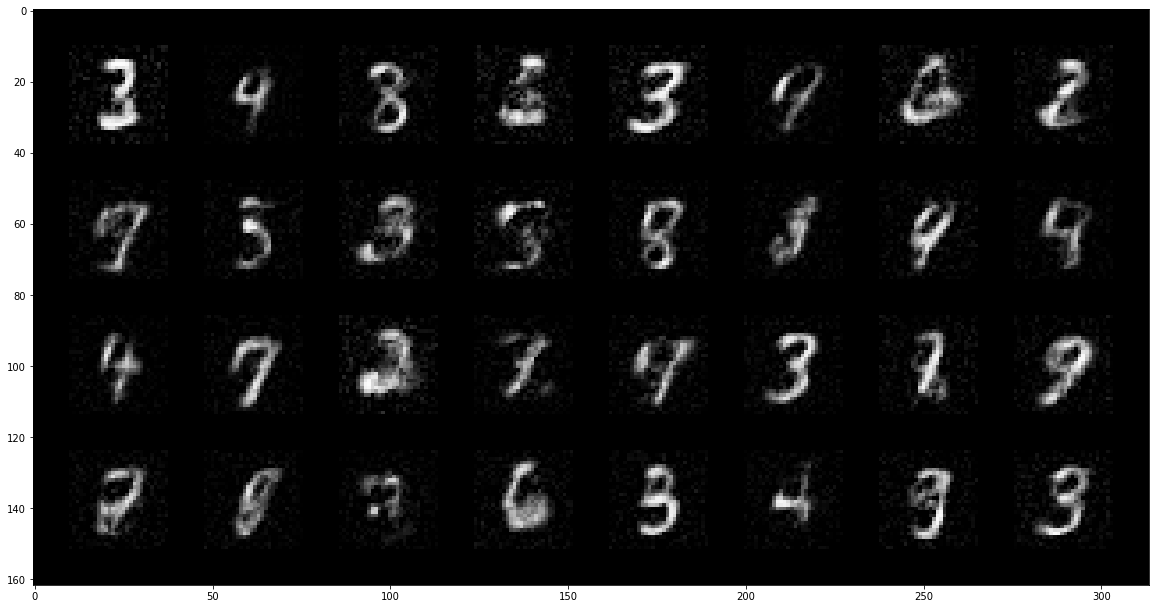

In [8]:
sample_images(generator, generator.noise(32).cpu())